# 二八轮动


二八轮动，指的是市值最大的前 20% 数量的大盘股和剩下数目占 80% 的中小盘股之间的轮动。经典二八轮动策略的主要驱动逻辑是动量。动量就是资产近期涨幅的横向排名，它与趋势很像，但多了一层横向比较：看谁过去涨得多或跌得少，然后就买谁。

二八轮动假设了市场资金的流动是有惯性的：当近期大盘股涨得多的时候，后续大概率资金还会持续地向大盘股流入；直到这个趋势难以持续下去的时候，资金又会向小盘股流动，而且这个趋势一旦开始，资金就又会一直往小盘股流入。


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from enum import Enum

import ipywidgets as widgets
from ipywidgets import DatePicker, Dropdown, Select, Layout, Button, Box, VBox


额外为 matplotlib 加载中文字体


In [2]:
# download font file
font_file = '../../res/MicrosoftYaHei.ttf'
!(FONT_FILE=../../res/MicrosoftYaHei.ttf && [ ! -f ${FONT_FILE} ] && curl "https://raw.githubusercontent.com/hdouhua/ml-in-action/main/res/Microsoft%20YaHei.ttf" -o ${FONT_FILE})

# set font
from matplotlib import font_manager
font_manager.fontManager.addfont(font_file)
# plt.rc('font', family='Microsoft YaHei')
# or
plt.rcParams['font.family'] = 'Microsoft YaHei'

策略逻辑

In [3]:
# %run ./shared/tools.py
from shared.tools import get_drawdown, cal_period_perf_indicator, datestr2dtdate


class RotationType(Enum):
    """
    1 - 满仓
    2- 可空仓
    3 - 增强
    """
    Full = 1
    Nullable = 2
    Enhanced = 3


def _get_T_dates():
    # T 值的区间
    return [
        datetime.date(2010, 10, 11),
        datetime.date(2012, 8, 31),
        datetime.date(2015, 4, 7),
        datetime.date(2016, 1, 14),
        datetime.date(2017, 10, 30),
        datetime.date(2019, 1, 2),
        datetime.date(2021, 2, 9),
        datetime.date(2022, 3, 14),
    ]


def run_strategy(index_price, rotation_type, params):
    N = params['N']
    start_date = params['start_date']
    end_date = params['end_date']

    df = index_price.copy()
    df = df.loc[start_date:end_date]
    df['ret_large'] = df['large'].pct_change()
    df['ret_small'] = df['small'].pct_change()
    df['N_day_ret_large'] = df['large'] / df['large'].shift(N) - 1
    df['N_day_ret_small'] = df['small'] / df['small'].shift(N) - 1

    # 设置仓位：在 large OR small
    df['momentum_large_vs_small'] = df['N_day_ret_large'] - df['N_day_ret_small']
    df['pos_large'] = [1 if e > 0 else 0 for e in df['momentum_large_vs_small'].shift(1)]
    df['pos_small'] = 1 - df['pos_large']

    if rotation_type == RotationType.Full:
        pass
    elif rotation_type == RotationType.Nullable:
        df['pos_large'] = 0
        df['pos_small'] = 0
        for i in range(1, len(df)):
            t = df.index[i]
            t0 = df.index[i - 1]
            if df.loc[t0, 'N_day_ret_large'] >= df.loc[t0, 'N_day_ret_small'] and df.loc[t0, 'N_day_ret_large'] > 0:
                df.loc[t, 'pos_large'] = 1
            elif df.loc[t0, 'N_day_ret_small'] > df.loc[t0, 'N_day_ret_large'] and df.loc[t0, 'N_day_ret_small'] > 0:
                df.loc[t, 'pos_small'] = 1
    elif rotation_type == RotationType.Enhanced:
        t_date_range = _get_T_dates()
        # 可空仓区间：T <= 1.8
        for i in range(1, len(df)):
            t = df.index[i]
            if t <= t_date_range[1] or (t >= t_date_range[2] and t <= t_date_range[3]) \
                or (t >= t_date_range[4] and t <= t_date_range[5]) \
                or (t >= t_date_range[6] and t <= t_date_range[7]):
                t0 = df.index[i - 1]
                if df.loc[t0, 'N_day_ret_large'] >= df.loc[t0, 'N_day_ret_small'] and df.loc[t0, 'N_day_ret_large'] > 0:
                    df.loc[t, 'pos_large'] = 1
                elif df.loc[t0, 'N_day_ret_small'] > df.loc[t0, 'N_day_ret_large'] and df.loc[t0,
                                                                                              'N_day_ret_small'] > 0:
                    df.loc[t, 'pos_small'] = 1
                else:
                    df.loc[t, 'pos_large'] = 0
                    df.loc[t, 'pos_small'] = 0
    else:
        raise NotImplemented(f'not supported rotation_type [{rotation_type}]')

    # 计算获利
    df['ret_stgy'] = df['ret_large'] * df['pos_large'] + df['ret_small'] * df['pos_small']
    df['large'] = (1 + df['ret_large']).cumprod().fillna(1)
    df['small'] = (1 + df['ret_small']).cumprod().fillna(1)
    df['stgy'] = (1 + df['ret_stgy']).cumprod().fillna(1)

    return df


def backtest_result(df, title):
    ret_df = df.loc[:, ['large', 'small', 'stgy']]

    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.set_title(title)
    ret_df.plot(ax=ax1, grid=True)
    plt.xlim(df.index[0], df.index[-1])

    ax2 = fig.add_subplot(2, 1, 2)
    df[['pos_large', 'pos_small']].plot(ax=ax2, kind='area', stacked=True, grid=True)
    plt.xlim(df.index[0], df.index[-1])

    res = cal_period_perf_indicator(ret_df)
    res['TotalRet'] = ret_df.iloc[-1] - 1
    print(res)

加载测试数据


In [4]:
# # index_price = pd.read_csv('../res/指数历史数据.csv').set_index('datetime')
# index_price = pd.read_csv('../res/main-indices-data.csv').set_index('datetime')
# index_price.index = [datestr2dtdate(e) for e in index_price.index]


def _load_from_csv(csv_file, cols=None):
    df = pd.read_csv(csv_file).set_index('datetime')
    df.index = [datestr2dtdate(e) for e in df.index]
    df.drop(['acc_close', 'pe', 'pe_pct80', 'pe_pct20', 'pe_pct50'], axis=1, inplace=True)
    if cols:
        df.rename(columns=cols, inplace=True)

    # print(df.head(50))
    return df


def load_data(small_index, large_index):
    small_price = _load_from_csv(f'../res/small/{small_index}.csv', cols={
        'close': 'small',
        'pe_pct': 'small_pe_pct',
    })
    large_price = _load_from_csv(f'../res/large/{large_index}.csv', cols={
        'close': 'large',
        'pe_pct': 'large_pe_pct',
    })

    return pd.merge(large_price, small_price, left_index=True, right_index=True)


设置回测参数


In [5]:
datePickers = [
    DatePicker(value=datetime.date(2020, 1, 1),
               description='Start:',
               disabled=False,
               layout=Layout(flex='1 1 auto', width='auto')),
    DatePicker(value=datetime.date(2022, 12, 16),
               description='End:',
               disabled=False,
               layout=Layout(flex='1 1 auto', width='auto')),
    widgets.IntSlider(value=21,
                      min=5,
                      max=100,
                      step=1,
                      description='N days:',
                      disabled=False,
                      continuous_update=False,
                      orientation='horizontal',
                      readout=True,
                      readout_format='d'),
]
symbols = [
    Select(options=[
        ('中证500', '000905'),
        ('500质量', '930939'),
        ('沪港深500', '30455'),
        ('500SNLV', '930782'),
        ('500成长估值', '930938'),
        ('创成长', '930938'),
        ('创业板指', '399006'),
        ('中小板指', '399005'),
    ],
           value='000905',
           rows=10,
           description='Small-Cap:',
           disabled=False),
    Select(options=[
        ('沪深300', '000300'),
        ('300价值', '000919'),
        ('沪港深300', '931395'),
        ('300质量', '931155'),
        ('300成长', '000918'),
        ('深证300', '399007'),
        ('300消费', '000912'),
    ],
           value='000300',
           rows=10,
           description='Large-Cap:',
           disabled=False),
]

box1 = Box(children=datePickers)
box2 = Box(children=symbols)
VBox(children=(box1, box2))

In [6]:
params = {'start_date': datePickers[0].value, 'end_date': datePickers[1].value, 'N': datePickers[2].value}
small_index = symbols[0].value
large_index = symbols[1].value

print(f"to load data {small_index} and {large_index} with params start-[{params['start_date'] }], end-[{params['end_date']}] and N-[{params['N']}] days")
index_price = load_data(small_index, large_index)


to load data 000905 and 000300 with params start-[2020-01-01], end-[2022-12-16] and N-[21] days


下面回测以沪深 300 指数和中证 500 指数为交易标的，其中沪深 300 指数代表大盘股，中证 500 指数代表中小盘股。每天回看这两个指数最近 N 个交易日的涨幅，当沪深 300 的区间涨幅大于中证 500 时，持有沪深 300；当中证 500 的区间涨幅大于沪深 300 时，持有中证 500。

## 二八轮动：满仓版本


         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
large -0.016334  0.203249 -0.080364 -0.395856 -0.041262 -0.047688
small  0.042581  0.210388  0.202394 -0.315704  0.134878  0.131700
stgy   0.078803  0.202887  0.388407 -0.285495  0.276021  0.252383


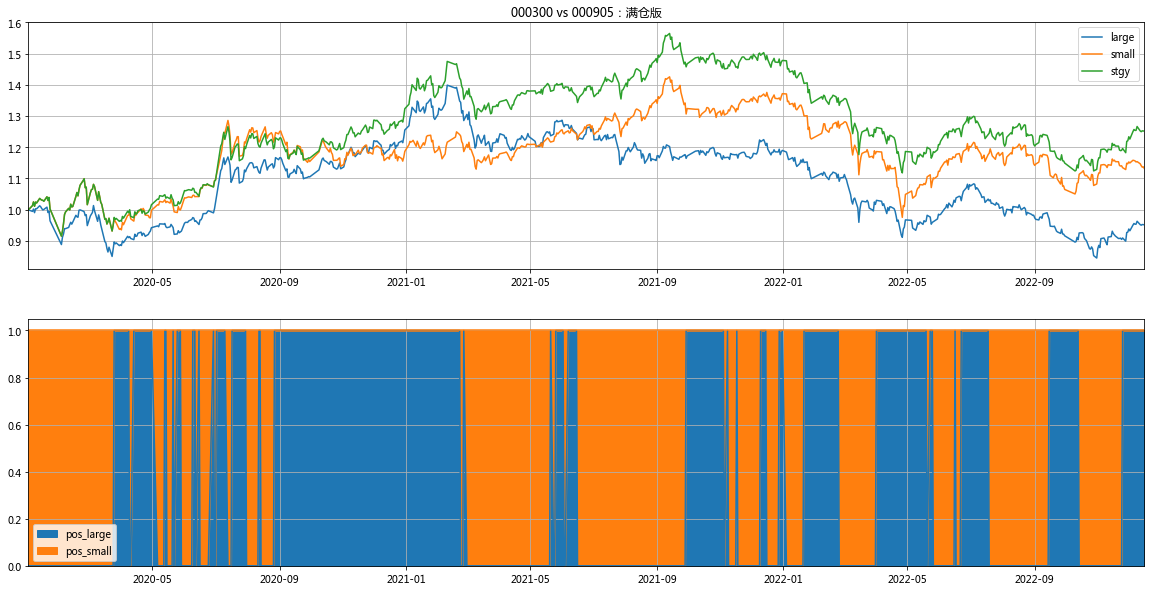

In [7]:
df = run_strategy(index_price, rotation_type=RotationType.Full, params=params)

backtest_result(df, title=f'{large_index} vs {small_index}：满仓版')

<hr />

## 二八轮动：可空仓版

总是满仓版本的二八轮动虽然性价比很高，但回撤水平仍然不是普通个人投资者能接受的。可以空仓的版本，它与前面版本的唯一差异就是，当回看 N 个交易日涨幅时，如果两个指数均为下跌，就选择空仓。


         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
large -0.016334  0.203249 -0.080364 -0.395856 -0.041262 -0.047688
small  0.042581  0.210388  0.202394 -0.315704  0.134878  0.131700
stgy   0.050738  0.148123  0.342543 -0.176707  0.287133  0.158173


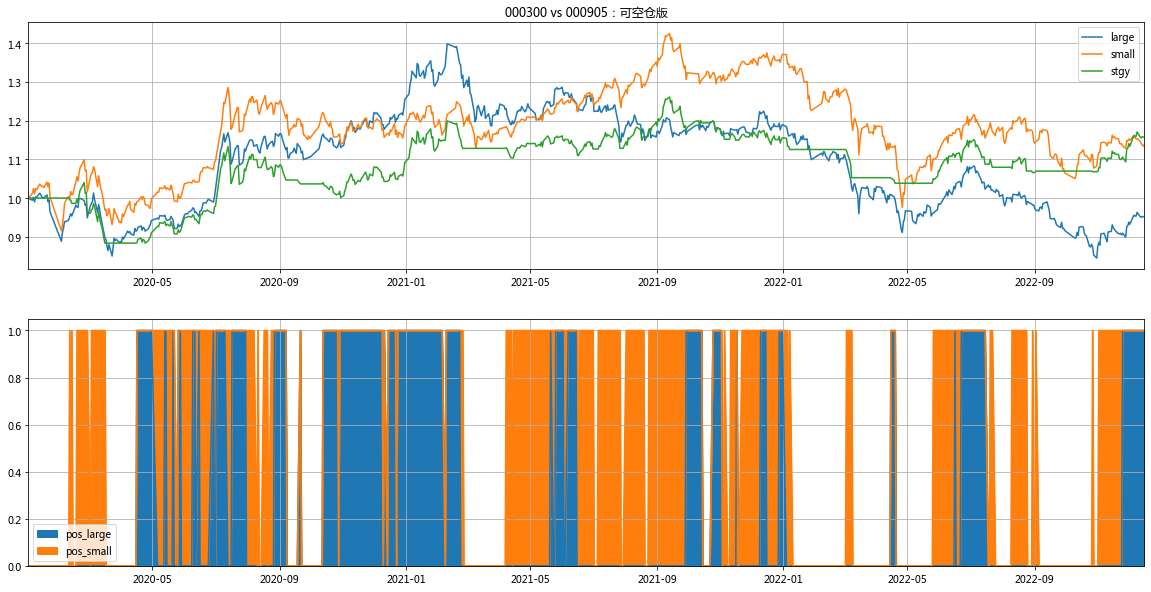

In [8]:
df = run_strategy(index_price, rotation_type=RotationType.Nullable, params=params)

backtest_result(df, title=f'{large_index} vs {small_index}：可空仓版')

美中不足：因为策略会空仓，所以 2019 到 2020 两年的慢牛行情中获利不多——这是降低最大回撤的合理代价。

<hr />


## 二八轮动：增强版

——满仓和可空仓结合体，基于股市温度决定使用满仓版还是可空仓版。

股市温度由 沪深 300 收益率 和 十年期国债 比值 T 来衡量:

- T >= 3 : 股市温度低，也就是寒冬，非常有吸引力
- T <= 1.8 : 股市温度很高，大夏天，风险高于回报了，不具有吸引力

[T 值参考](http://www.dashiyetouzi.com/tools/compare/hs300_10gz_pro.php)


         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
large -0.016334  0.203249 -0.080364 -0.395856 -0.041262 -0.047688
small  0.042581  0.210388  0.202394 -0.315704  0.134878  0.131700
stgy   0.092454  0.193569  0.477627 -0.251924  0.366991  0.299989


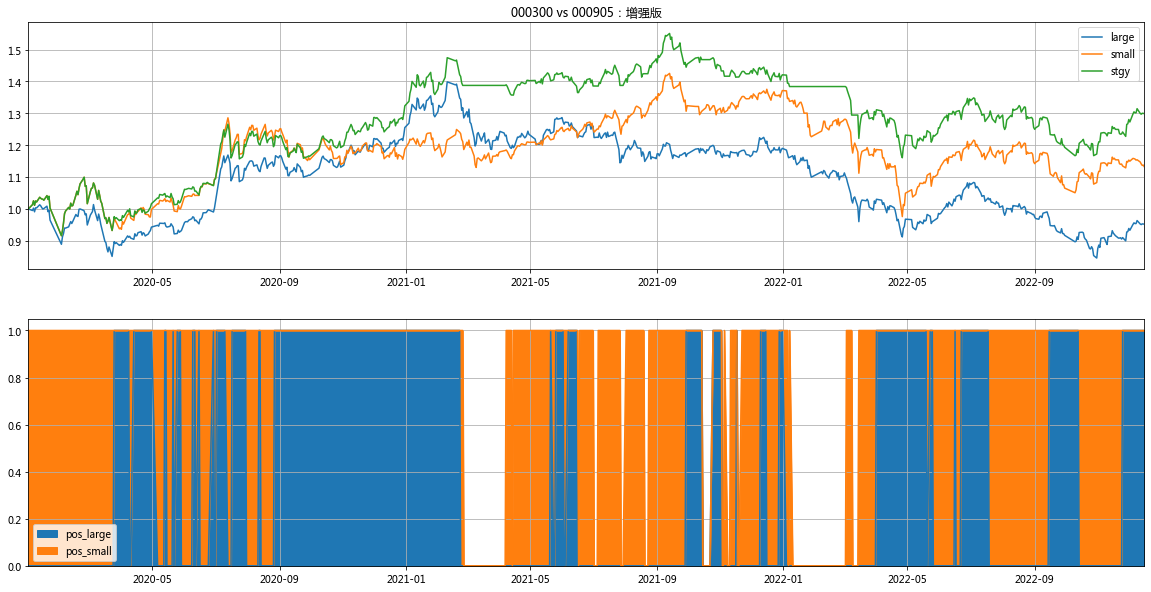

In [9]:
df = run_strategy(index_price, rotation_type=RotationType.Enhanced, params=params)

backtest_result(df, title=f'{large_index} vs {small_index}：增强版')